In [1]:
import numpy as np
import tensorflow as tf
from parsing import DependencyParser, load_examples

%matplotlib inline
%load_ext autoreload
%autoreload 2

/datadrive/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/datadrive/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/datadrive/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/datadrive/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

/datadrive/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/datadrive/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/datadrive/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/datadrive/anaconda3/lib/python3.7/site-packages/tensorboard/compat

### Данные

In [2]:
data_path_train = "/datadrive/vm_admin/data/conll/ru_syntagrus-ud-train.conllu"
data_path_dev = "/datadrive/vm_admin/data/conll/ru_syntagrus-ud-dev.conllu"
data_path_test = "/datadrive/vm_admin/data/conll/ru_syntagrus-ud-test.conllu"

examples_train, arc2id, pos2id = load_examples(data_path_train)
id2arc = {v: k for k, v in arc2id.items()}
id2pos = {v: k for k, v in pos2id.items()}

examples_dev = load_examples(data_path_dev, arc2id=arc2id, pos2id=pos2id)[0]
examples_test = load_examples(data_path_test, arc2id=arc2id, pos2id=pos2id)[0]

num examples: 47962
num strange: 1047
num arc types: 41
num examples: 6425
num strange: 204
num arc types: 40
num examples: 6347
num strange: 194
num arc types: 40


### Модель

* config

In [6]:
config = {
    "emb": {
        "elmo_dir": "/datadrive/vm_admin/nn_lfs/pretrained/my_elmo_warmed_up/",
        "elmo_dropout": 0.2,
        "use_pos": True,
        "concat": False,
        "num_pos_labels": len(pos2id),
        "pos_emb_dim": 1024,
        "pos_emb_dropout": 0.2,
        "combined_dropout": 0.2,
        "layernorm": True
    },
    "attention": {
        "num_layers": 8,
#         "num_layers": 12,
        "num_heads": 8,
        "head_dim": 64,
        "dff": 2048,
        "dropout_rc": 0.2,
        "dropout_ff": 0.2
    },
    "parser": {
        "mlp": {
            "num_layers": 1,
            "dropout": 0.33
        },
        "arc": {
            "hidden_dim": 1024
        },
        "type": {
            "num_labels": len(arc2id),
            "hidden_dim": 256
        }
    },
    "opt": {
#         "opt_name": "adamw",
        "opt_name": "adam",
        "num_accumulation_steps": 4,
        "init_lr": 0.0008,
#         "warmup_steps": 1000,
        "warmup_steps": 180,
#         "clip_grads": False,
        "clip_grads": True,
        "clip_norm": 1.0
    }
}

* model

In [7]:
tf.reset_default_graph()
sess = tf.Session()
parser = DependencyParser(sess, config)
parser.build()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
for v in tf.trainable_variables():
    print(v.name, "\t", v.shape, "\t", np.prod(v.shape))
print()
print(int(sum(np.prod(x.shape) for x in tf.trainable_variables())))

dependency_parser/embedding/embeddings:0 	 (19, 1024) 	 19456
dependency_parser/layer_normalization/gamma:0 	 (1024,) 	 1024
dependency_parser/layer_normalization/beta:0 	 (1024,) 	 1024
dependency_parser/dense/kernel:0 	 (1024, 512) 	 524288
dependency_parser/dense/bias:0 	 (512,) 	 512
dependency_parser/dot_product_attention/mha/dense_1/kernel:0 	 (512, 1536) 	 786432
dependency_parser/dot_product_attention/mha/dense_1/bias:0 	 (1536,) 	 1536
dependency_parser/dot_product_attention/layer_normalization_1/gamma:0 	 (512,) 	 512
dependency_parser/dot_product_attention/layer_normalization_1/beta:0 	 (512,) 	 512
dependency_parser/dot_product_attention/dense_2/kernel:0 	 (512, 2048) 	 1048576
dependency_parser/dot_product_attention/dense_2/bias:0 	 (2048,) 	 2048
dependency_parser/dot_product_attention/dense_3/kernel:0 	 (2048, 512) 	 1048576
dependency_parser/dot_product_attention/dense_3/bias:0 	 (512,) 	 512
dependency_parser/dot_product_attention/layer_normalization_2/gamma:0 	 (512,)

### train

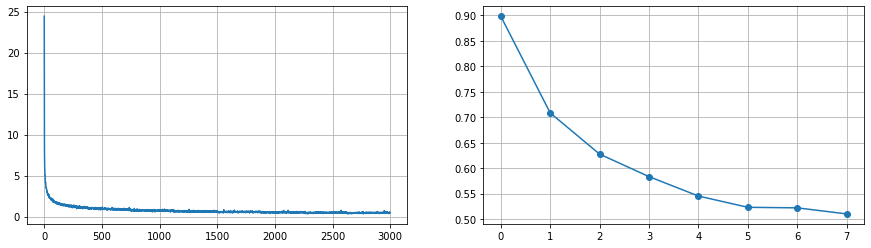

In [14]:
# 1 attn layer
num_epochs = 8
batch_size = 128
parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    eval_step=10
)

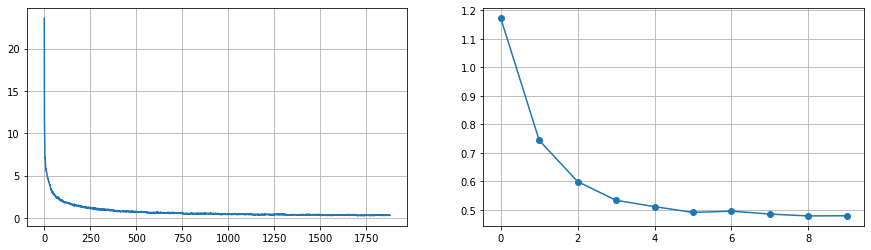

In [14]:
# num_attn_layers = 3, num_heads = 8, head_dim = 64, dropout = 0.2 (~6.8M params)
num_epochs = 10
batch_size = 256
maxlen = 110
parser.train(
    train_examples=[x for x in examples_train if len(x.tokens) <= maxlen],
    eval_examples=[x for x in examples_dev if len(x.tokens) <= maxlen],
    num_epochs=num_epochs, 
    batch_size=batch_size,
    eval_step=10
)

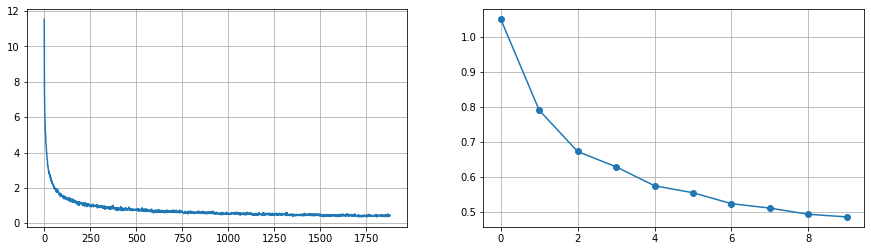

In [9]:
# num_attn_layers = 4, num_heads 2, head_dim = 32, dropout = 0.1 (~1.3M params)
num_epochs = 10
batch_size = 256
maxlen = 110
parser.train(
    train_examples=[x for x in examples_train if x.num_tokens <= maxlen],
    eval_examples=[x for x in examples_dev if x.num_tokens <= maxlen],
    num_epochs=num_epochs, 
    batch_size=batch_size,
    eval_step=10
)

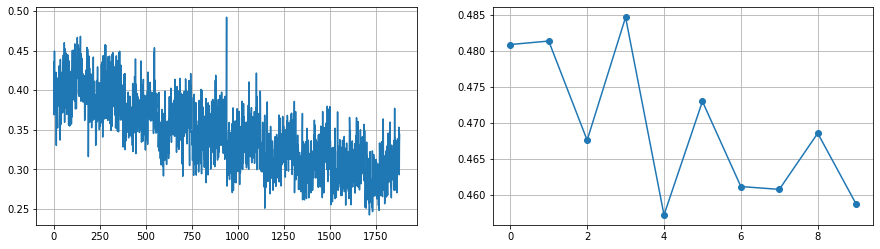

In [13]:
# + 10 epochs
num_epochs = 10
batch_size = 256
maxlen = 110
parser.train(
    train_examples=[x for x in examples_train if x.num_tokens <= maxlen],
    eval_examples=[x for x in examples_dev if x.num_tokens <= maxlen],
    num_epochs=num_epochs, 
    batch_size=batch_size,
    eval_step=10
)

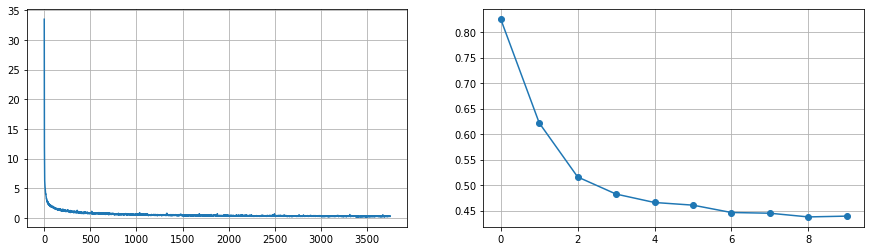

In [9]:
num_epochs = 10
# batch_size = 256
# maxlen = 110
batch_size = 128
maxlen = 11000

parser.train(
    train_examples=[x for x in examples_train if x.num_tokens <= maxlen],
    eval_examples=[x for x in examples_dev if x.num_tokens <= maxlen],
    num_epochs=num_epochs, 
    batch_size=batch_size,
    eval_step=10
)

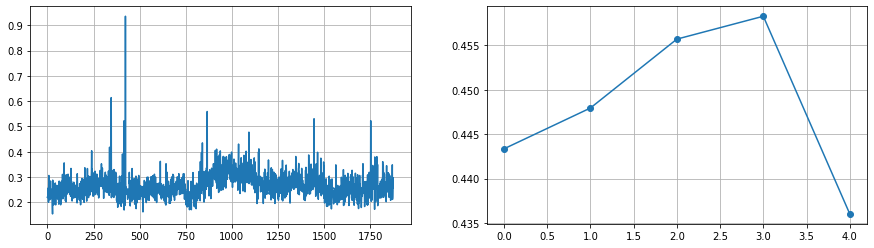

In [35]:
# + 5 epochs
num_epochs = 5
# batch_size = 256
# maxlen = 110
batch_size = 128
maxlen = 11000

parser.train(
    train_examples=[x for x in examples_train if x.num_tokens <= maxlen],
    eval_examples=[x for x in examples_dev if x.num_tokens <= maxlen],
    num_epochs=num_epochs, 
    batch_size=batch_size,
    eval_step=10
)

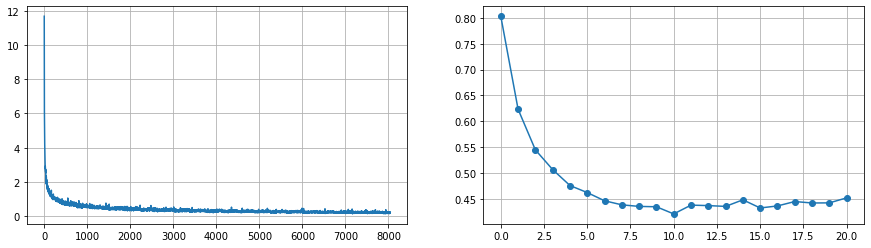

0.20055674
0.18042894
0.19053316
0.16552281
0.21578497
0.21957403
0.20817396


In [ ]:
num_epochs = 50
batch_size = 128

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    eval_step=10
)

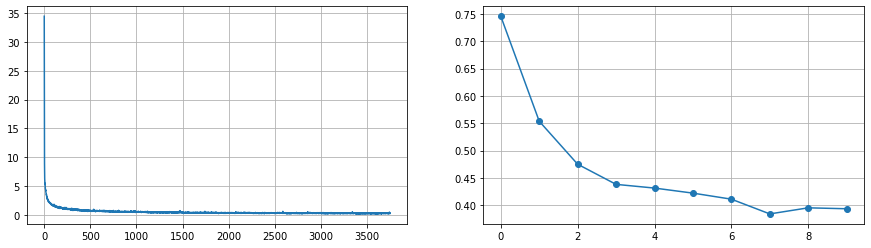

In [13]:
# 3attn, 8 heads, + pos tags
num_epochs = 10
batch_size = 128

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    eval_step=10
)

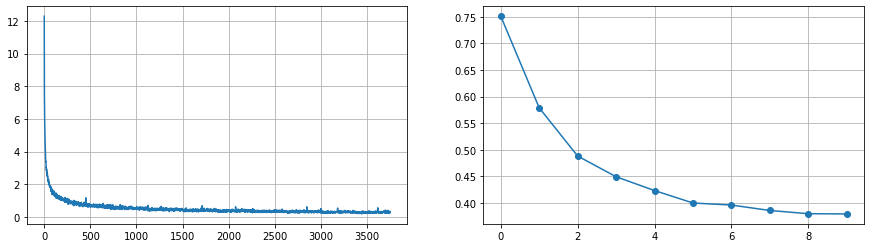

In [9]:
# 4attn, 2 heads, + pos tags
num_epochs = 10
batch_size = 128

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    eval_step=10
)

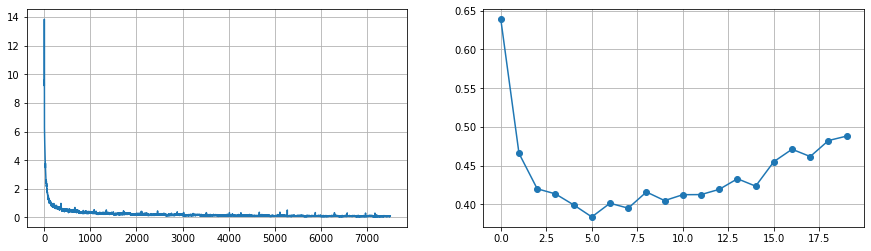

In [23]:
# 4 attn, 8 heads, x2 mlp, 1024 arc_dim
num_epochs = 20
batch_size = 128

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    eval_step=10
)

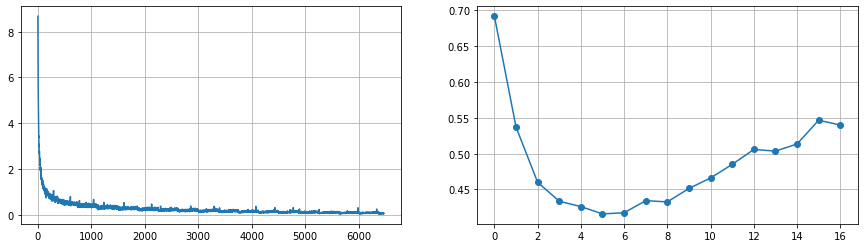

0.07401306
0.074254096
0.08026172
0.095693
0.0830591


In [ ]:
# 4 attn, 2 heads, x2 mlp, 1024 arc_dim
num_epochs = 20
batch_size = 128

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    eval_step=10
)

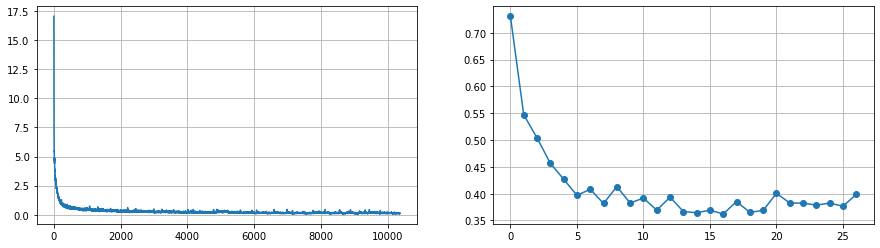

0.14190827
0.09810224
0.106794424
0.09308891
0.11562806
0.106530726
0.14694224
0.1081458


KeyboardInterrupt: 

In [9]:
# 4 attn, 8 heads, x1 mlp, 512 arc_dim
num_epochs = 30
batch_size = 128

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    eval_step=10
)

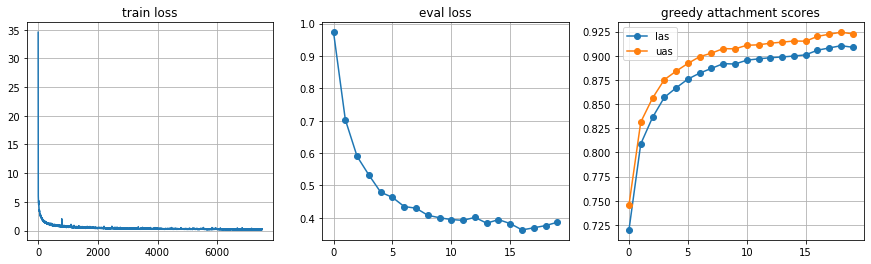

In [13]:
# 4 attn, 8 heads, x1 mlp, 512 arc_dim, enable mlp dropout
num_epochs = 20
batch_size = 128

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10
)

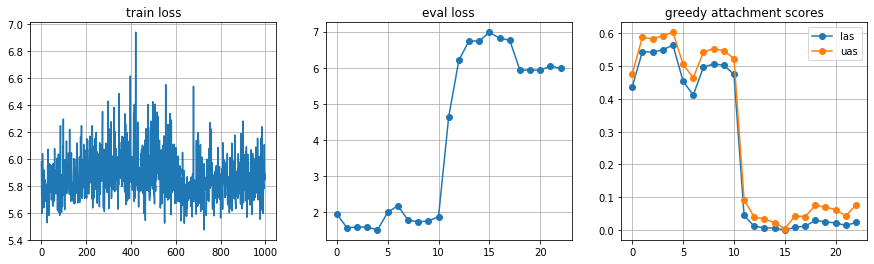

5.7124395
5.725051


KeyboardInterrupt: 

In [6]:
# 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type dim, 2048 dff, 0.2 pos-emb dropout
num_epochs = 30
batch_size = 100

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

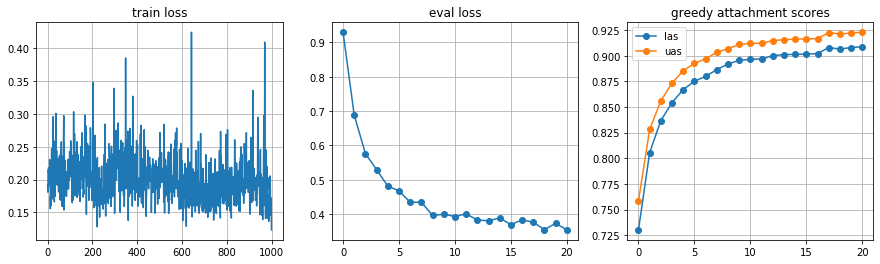

0.17859133
0.12954256
0.17041562
0.19423679
0.18735126
0.1501751
0.23081668
0.23169656


In [ ]:
# 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 128 type_dim, 1024 dff, 0.2 pos-emb dropout
num_epochs = 30
batch_size = 128

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

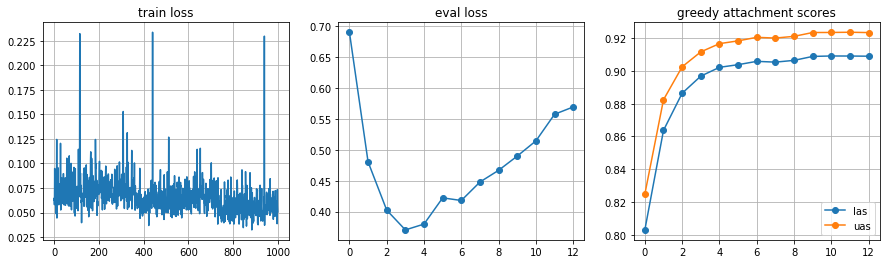

0.06855397
0.056508973


KeyboardInterrupt: 

In [6]:
# 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 128 type_dim, 2048 dff, 0.2 pos-emb dropout, noam-schedule
num_epochs = 20
batch_size = 128

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

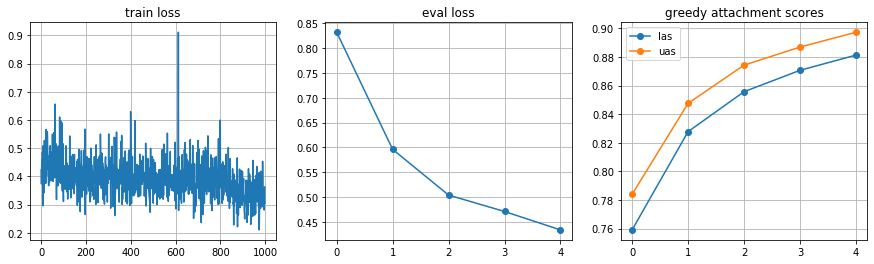

In [ ]:
# 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, noam-schedule
num_epochs = 20
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

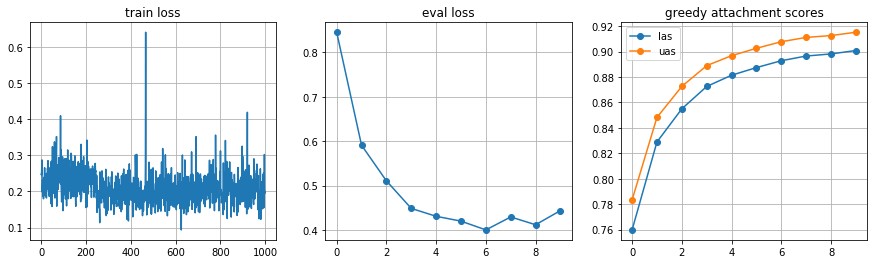

In [5]:
# 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule
num_epochs = 10
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

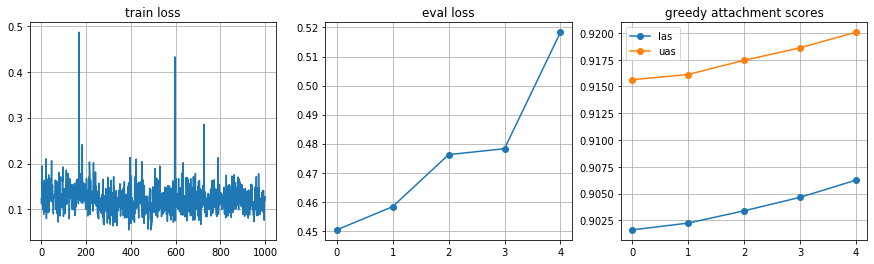

In [6]:
# 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule
# + 5 epochs
num_epochs = 5
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

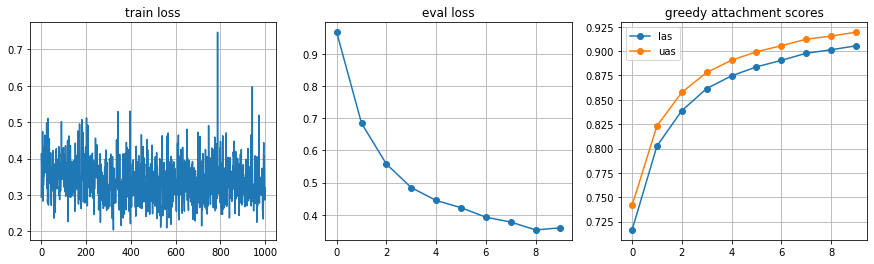

In [6]:
# 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule
# elmo dropout fix
num_epochs = 10
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

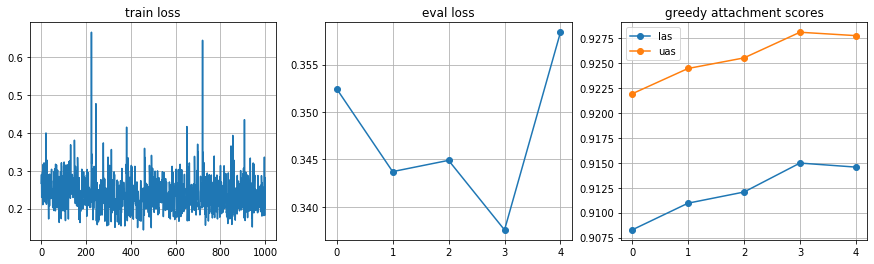

In [10]:
# 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule
# elmo dropout fix
# + 5 epochs
num_epochs = 5
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

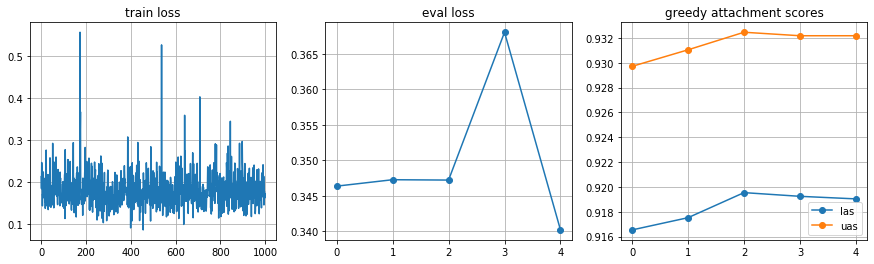

In [24]:
# 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule
# elmo dropout fix
# + 5 epochs
num_epochs = 5
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

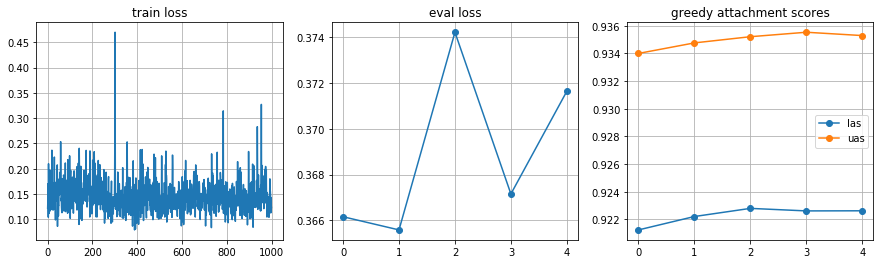

In [65]:
# 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule
# elmo dropout fix
# + 5 epochs
num_epochs = 5
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

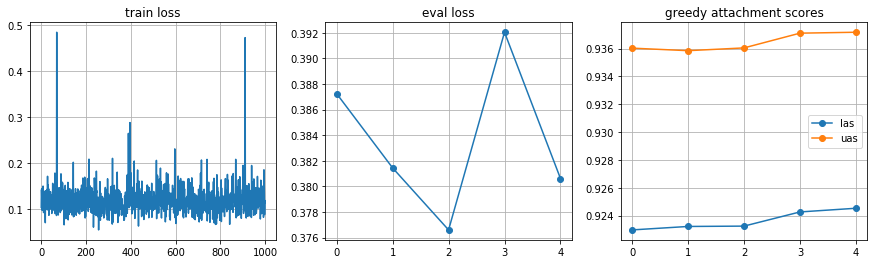

In [70]:
# 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule
# elmo dropout fix
# + 5 epochs
num_epochs = 5
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

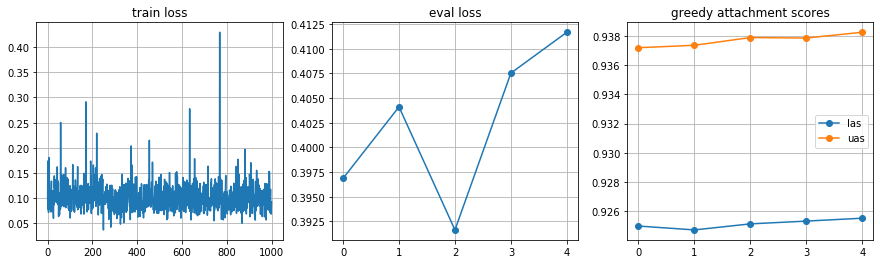

In [75]:
# 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule
# elmo dropout fix
# + 5 epochs
num_epochs = 5
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

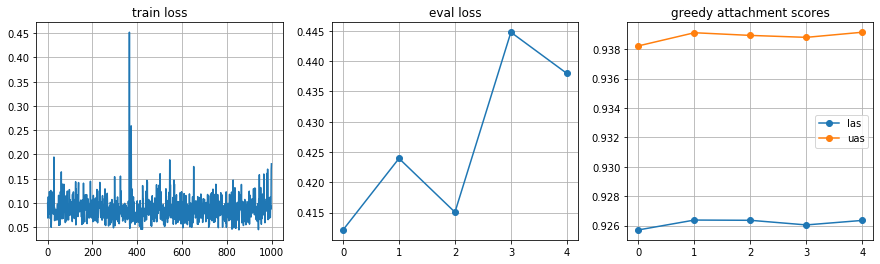

In [80]:
# 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule
# elmo dropout fix
# + 5 epochs
num_epochs = 5
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

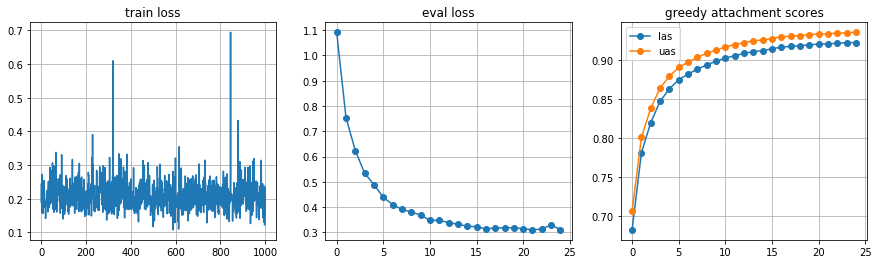

0.19214225
0.16542941
0.23957863


In [ ]:
# 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, 
# lr noam-schedule
num_epochs = 40
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

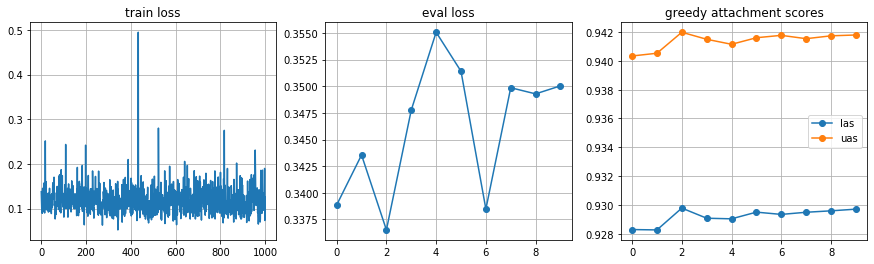

In [36]:
# 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, 
# lr noam-schedule
# + 10 epochs
num_epochs = 10
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

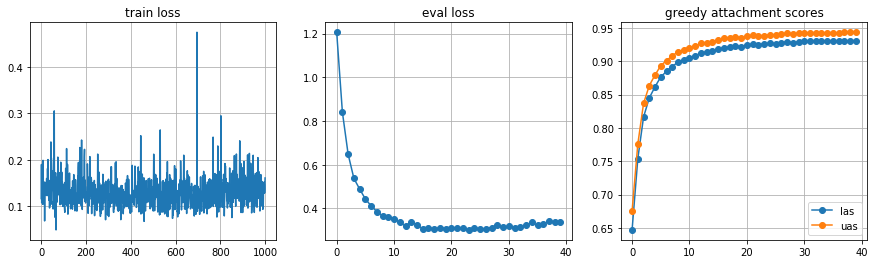

In [6]:
# 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, 
# lr noam-schedule
num_epochs = 40
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

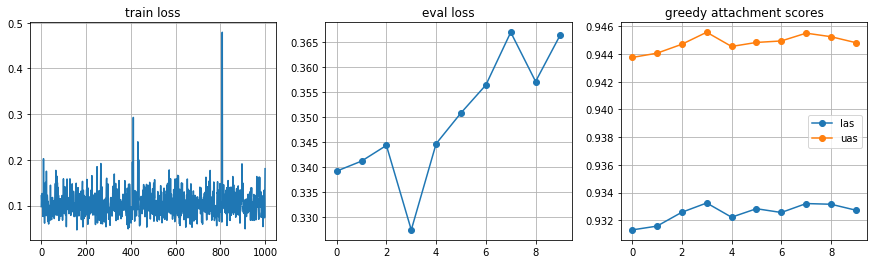

In [44]:
# 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, 
# lr noam-schedule
# + 10 epochs
num_epochs = 10
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=1000
)

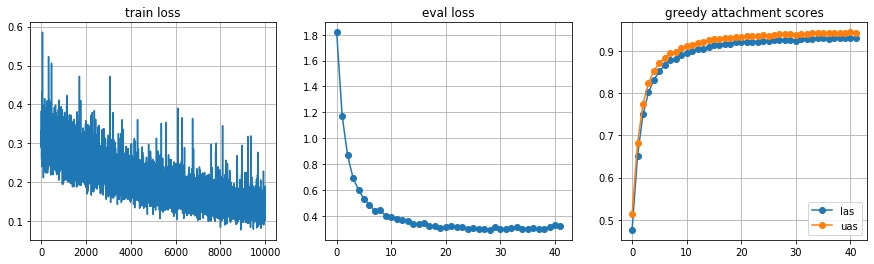

KeyboardInterrupt: 

In [24]:
# 12 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, 
# 4 grad acc steps (total bs = 128)
num_epochs = 50
batch_size = 32

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=10000
)

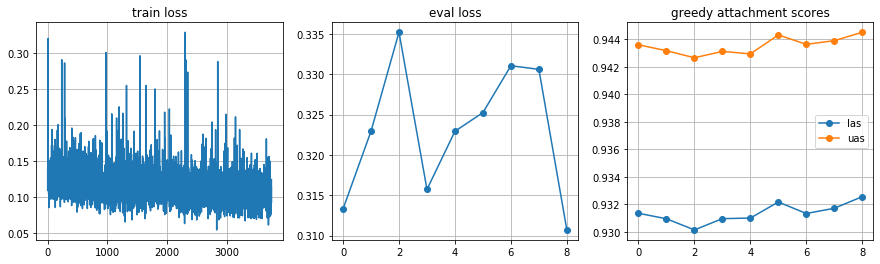

In [28]:
# 12 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, 
# 4 grad acc steps (total bs = 128)
# + 10 epochs
num_epochs = 10
batch_size = 32

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=10000
)

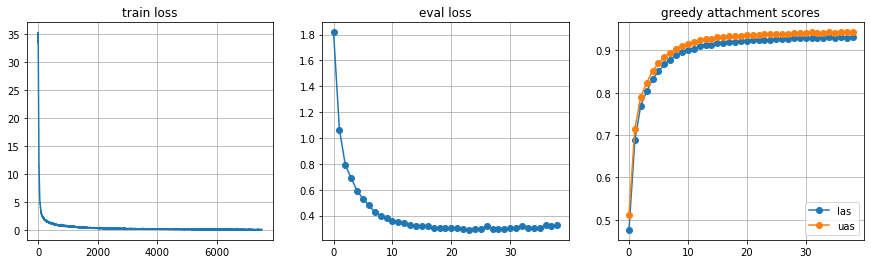

In [10]:
# 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, 
# 1000 warmup steps
# 4 grad acc steps (total bs = 256)
num_epochs = 40
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=10000
)

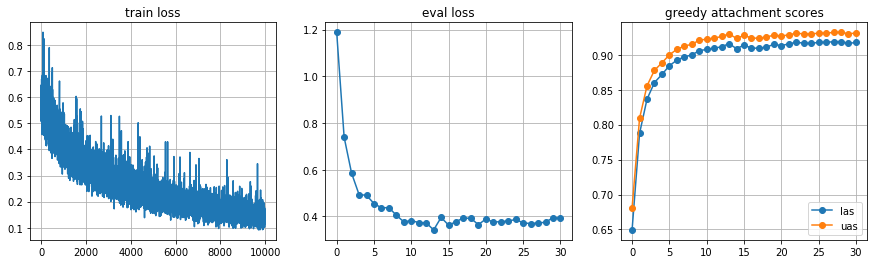

11626 0.15357408 True
11626 0.13490061 True
11627 0.16777049 True
11627 0.18474557 True
11628 0.1277767 True


KeyboardInterrupt: 

In [7]:
# 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, 
# 200 warmup steps
# 2 grad acc steps (total bs = 128)
num_epochs = 40
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=10000
)

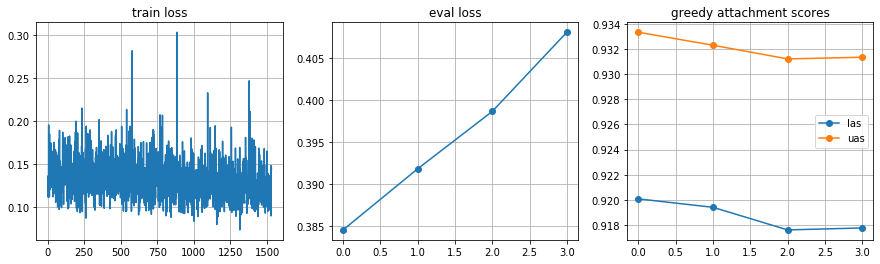

13159 0.12946299 True
13159 0.110242814 True
13160 0.13521102 True
13160 0.16015807 True
13161 0.12687463 True


KeyboardInterrupt: 

In [12]:
# 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, 
# 200 warmup steps
# 2 grad acc steps (total bs = 128)
# + 10 epochs
num_epochs = 10
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=10000
)

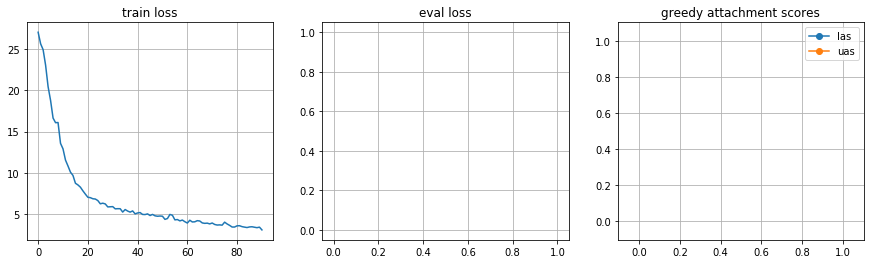

91 3.3412433 True
92 3.265298 True
93 3.2752204 True
94 3.186916 True
95 3.4315467 True
96 3.454825 True
97 3.1160874 True
98 3.5194557 True
99 7.66173 False


In [ ]:
# 8 attn, 8 heads, 2 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, 
# 200 warmup steps
# 1 grad acc steps (total bs = 64)
num_epochs = 40
batch_size = 64

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=10000
)

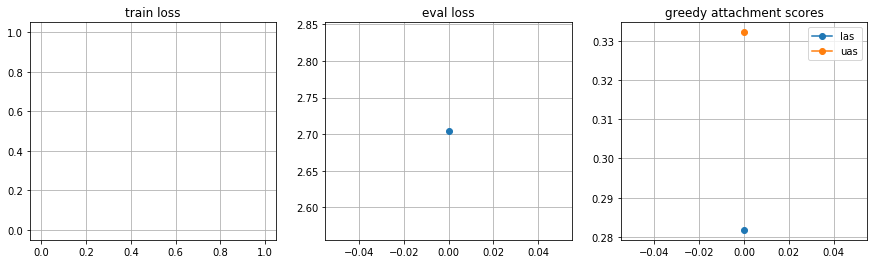

2.80013
2.4530282
2.3354182
2.5931065


KeyboardInterrupt: 

In [6]:
# 8 attn, 8 heads, 1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 dropout ff, emb layernorm, 
# 200 warmup steps, no grad acc
num_epochs = 40
batch_size = 32

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=10000
)

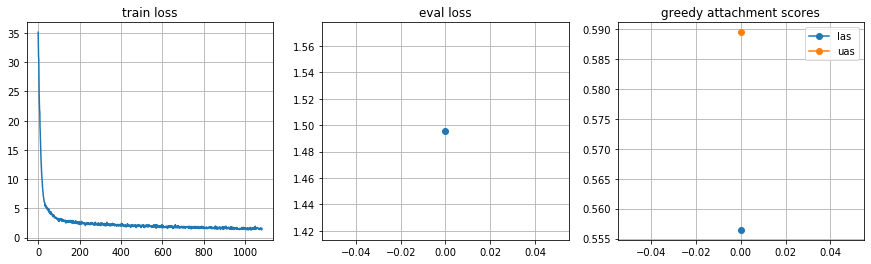

1081 1.332583 True
1081 1.6004285 True
1082 1.4097977 True
1082 1.8821232 True
1083 1.4825673 True
1083 1.7126809 True
1084 1.5426551 True
1084 1.7557743 True
1085 1.5085776 True
1085 1.3210571 True
1086 1.5760627 True
1086 1.6797916 True
1087 1.3200516 True
1087 1.3815818 True
1088 1.2726552 True
1088 1.3898718 True
1089 1.6453329 True
1089 1.3986237 True


KeyboardInterrupt: 

In [5]:
# 8 attn, 8 heads, 1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 dropout ff, emb layernorm, 
# 200 warmup steps, 2 acc steps (total bs = 64)
num_epochs = 40
batch_size = 32

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=10000
)

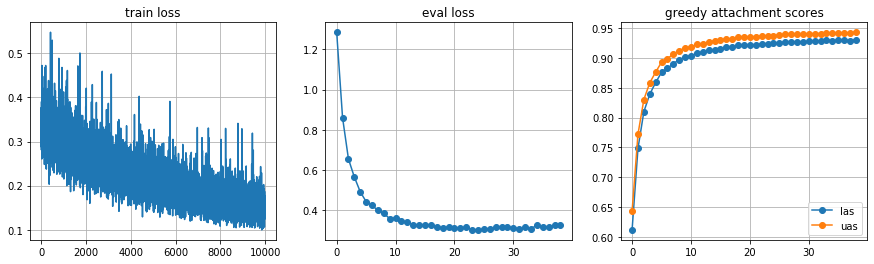

In [8]:
# 8 attn, 8 heads, 1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 dropout ff, emb layernorm, 
# 200 warmup steps, 4 acc steps (total bs = 128)
num_epochs = 40
batch_size = 32

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=10000
)

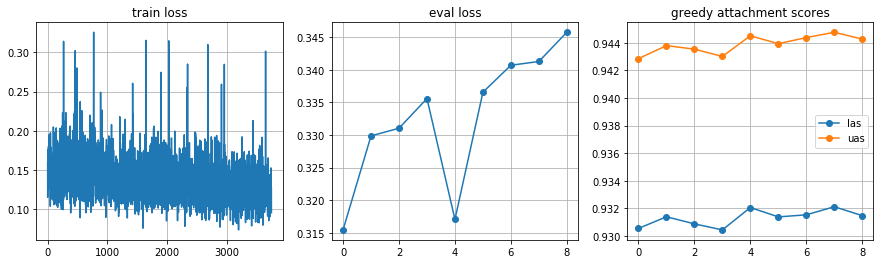

In [13]:
# 8 attn, 8 heads, 1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 dropout ff, emb layernorm, 
# 200 warmup steps, 4 acc steps (total bs = 128)
# + 10 epochs
num_epochs = 10
batch_size = 32

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=10000
)

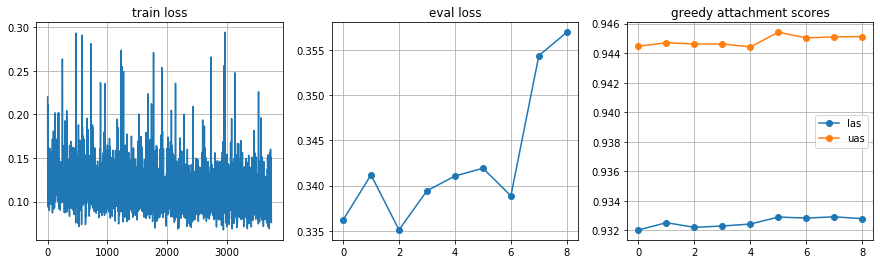

In [18]:
# 8 attn, 8 heads, 1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 dropout ff, emb layernorm, 
# 200 warmup steps, 4 acc steps (total bs = 128)
# + 10 epochs
num_epochs = 10
batch_size = 32

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=10000
)

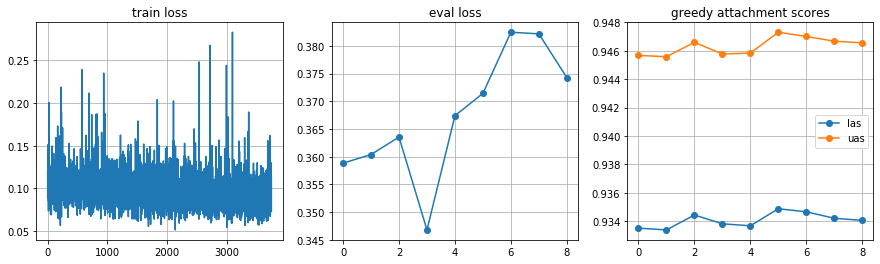

In [41]:
# 8 attn, 8 heads, 1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 dropout ff, emb layernorm, 
# 200 warmup steps, 4 acc steps (total bs = 128)
# + 10 epochs
num_epochs = 10
batch_size = 32

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=10000
)

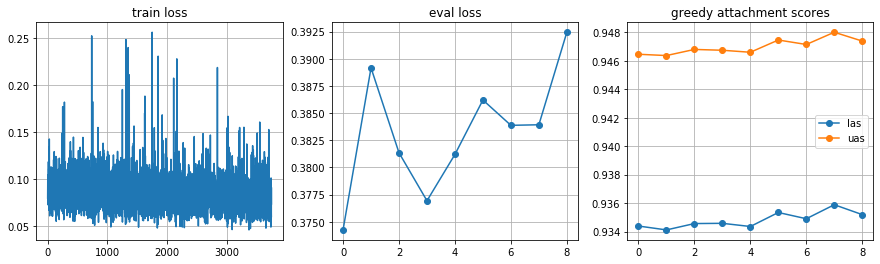

In [77]:
# 8 attn, 8 heads, 1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 
# 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 dropout ff, emb layernorm, 
# 200 warmup steps, 4 acc steps (total bs = 128)
# + 10 epochs
num_epochs = 10
batch_size = 32

parser.train(
    train_examples=examples_train,
    eval_examples=examples_dev,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    plot_step=10,
    plot_train_steps=10000
)

### predict

In [96]:
# если инет отрубился и графики выше не дорисовались
def f():
    losses_tmp = []
    las_tmp = []
    uas_tmp = []
    for start in range(0, len(examples_dev), batch_size):
        end = start + batch_size
        examples_batch = examples_dev[start:end]
        feed_dict = parser._get_feed_dict(examples_batch, training=False)
        loss, s_arc, s_type = parser.sess.run([parser.loss, parser.s_arc, parser.s_type], feed_dict=feed_dict)
        losses_tmp.append(loss)

        s_arc_argmax = s_arc.argmax(-1)  # [N, T]
        s_type_argmax = s_type.argmax(-1)  # [N, T, T]
        for i, x in enumerate(examples_batch):
            for arc in x.arcs:
                j = arc[0]
                head_true_ij = arc[1]
                type_true_ij = arc[2]
                head_pred_ij = s_arc_argmax[i, j]
                flag_arc = head_true_ij == head_pred_ij
                flag_type = s_type_argmax[i, j, head_pred_ij] == type_true_ij
                las_tmp.append(flag_arc & flag_type)
                uas_tmp.append(flag_arc)
    print(f"log-loss: {np.mean(losses_tmp)}; LAS: {np.mean(las_tmp)}; UAS: {np.mean(uas_tmp)}")

f()

log-loss: 0.3383118808269501; LAS: 0.9313387860525183; UAS: 0.9435494552799761


In [148]:
# from parsing import mst
# from tqdm import trange

# def _predict_batch(examples):
#     feed_dict = parser._get_feed_dict(examples, training=False)
#     s_arc, s_type, _ = parser.sess.run([parser.s_arc, parser.s_type, parser.loss], feed_dict=feed_dict)
#     preds = []
#     for i in range(len(examples)):
#         length_i = examples[i].num_tokens
#         s_arc_i = s_arc[i, :length_i, :length_i]
#         s_type_i = s_type[i, :length_i, :length_i]

#         indices_dep = range(length_i)
#         indices_head = mst(s_arc_i)
#         indices_type = s_type_i[indices_dep, indices_head].argmax(-1)

#         preds_i = list(zip(indices_head, indices_type))
#         preds.append(preds_i)
#     return preds

# def predict(examples, batch_size=128):
#     y_pred = []
#     for start in trange(0, len(examples), batch_size):
#         end = start + batch_size
#         examples_batch = examples[start:end]
#         y_pred += _predict_batch(examples_batch)
#     return y_pred

In [78]:
y_pred = parser.predict(examples_test)
# y_pred = predict(examples_test)

100%|██████████| 50/50 [01:37<00:00,  1.95s/it]


### evaluate

* все токены

In [79]:
from itertools import chain
y_true = [[y[1:] for y in x.arcs] for x in examples_test]
parser.evaluate(list(chain(*y_true)), list(chain(*y_pred)))

(0.9420490111207298, 0.9524455616967437)

In [21]:
# (0.8237250080188175, 0.8493638404789907) - epochs 5, bs 128, no attention, no pos-tags
# (0.8235646316689832, 0.8494172992622688) - epochs 10, bs 128, no attention, no pos-tags
# (0.8427242595958516, 0.8607398695605688) - epochs 5, bs 128,no attention, pos-tags

# (0.8757158553639209, 0.8944862489178931) - epochs 8, bs 128, 1 attention, no pos-tags
# (0.8796863554638077, 0.8976410068588933) - epochs 10, bs 128, 1 attention, no pos-tags
# (0.8953019910767797, 0.9134480921622161) - epochs 10, bs 128, 3 attention, no pos-tags
# (0.8957847772524472, 0.913672837450889) - epochs 12, bs 128, 3 attention, no pos-tags
# (0.8971665445828062, 0.9154291802623693) - 10 epochs, 256 bs, 3 attention, no pos-tags
# (0.8757824465605647, 0.8965006326163681) - 10 epochs, 256 bs, 4 attn, 2 heads, 32 hd, 1024 dff, no pos-tags
# (0.8914064060731172, 0.9102850103216354) - 20 epochs, 256 bs, 4 attn, 2 heads, 32 hd, 1024 dff, no pos-tags
# (0.9047329693014583, 0.9210977558766731) - 10 epochs, 128 bs, 3 attn, parserV2
# (0.9066474662049677, 0.9230871678764068) - 15 epochs, 128 bs, 3 attn, parserV2
# (0.9046663781048145, 0.9211726709728973) - 50 epochs, 128 bs, 3 attn, parserV2
# (0.9105347273090497, 0.9231121395751481) - 10 epochs, 128 bs, 3 attn, parserV2, pos-tags
# (0.9026186988080176, 0.9159036425384565) - 10 epochs, 128 bs, 4 attn, parserV2, pos-tags
# (0.9206732369980688, 0.9327095957914364) - 25 epochs, 128 bs, 4 attn, 8 heads, 64 hd, 1024 dff, parserV2, pos-tags, 1024 pos-dim, no concat
# (0.9198075514416995, 0.9321518945195445) - 20 epochs, 128 bs, 4 attn, 8 head, 64 hd, 1024, dff, parserV2, pos-tags, 1024 pos-dim, no concat, enable mlp dropout
# (0.9183258973163748, 0.9305370580009322)
# (0.9180012652327363, 0.9304954385030298) - 13 epochs, 128 bs, 4 attn, 8 heads, 64 hd, 2048 dff, pos-tags, 1024 pos-dim, no concat, enable mlp dropout, noam scheme
# (0.9167942997935673, 0.9293633881600852) - 20 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, noam-schedule
# (0.9292302057667976, 0.9400263035226744) - 20 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule, elmo dropout fix
# (0.9318688819338083, 0.942856429380036) - 25 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule, elmo dropout fix
# (0.9331507624692016, 0.943855297329693) - 30 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule, elmo dropout fix
# (0.9345158820003996, 0.9450539388692815) - 35 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule, elmo dropout fix
# (0.9347406272890724, 0.9451038822667643) - 35 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule, elmo dropout fix
# (0.9376373443430779, 0.9478840647266431) - 40 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, noam-schedule, elmo dropout fix
# (0.9379536525271359, 0.9480422188186721) - 50 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, noam-schedule, elmo dropout fix
# (0.9398015582340015, 0.9499816874209229) - 40 epochs, 64 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, noam-schedule, elmo dropout fix
# (0.941491309848838, 0.9514133981487647) - 50 epochs, 64 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, noam-schedule, elmo dropout fix
# (0.938919224878471, 0.9494073383498701) - 40 epochs, 128 bs, 12 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, noam-schedule, 1000 warmup steps
# (0.9405090896983419, 0.950472797496171) - 50 epochs, 128 bs, 12 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, noam-schedule, 1000 warmup steps
# (0.939618432443231, 0.9495904641406406) - 40 epochs, 256 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, noam-schedule, 1000 warmup steps
# (0.9378287940334288, 0.9486082439901445) - 30 epochs, 128 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, noam-schedule, 200 warmup steps
# (0.9385945927948325, 0.9491742691616168) - 40 epochs, 128 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 ff dropout, emb layernorm, noam-schedule, 200 warmup steps
# (0.9409669041752681, 0.9513051874542185) - 50 epochs, 128 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 ff dropout, emb layernorm, noam-schedule, 200 warmup steps
# (0.94117500166478, 0.9513468069521209) - 60 epochs, 128 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 ff dropout, emb layernorm, noam-schedule, 200 warmup steps
# * (0.9426733035892655, 0.9528201371778651) - 70 epochs, 128 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 ff dropout, emb layernorm, noam-schedule, 200 warmup steps
# (0.9420490111207298, 0.9524455616967437) - 80 epochs, 128 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 ff dropout, emb layernorm, noam-schedule, 200 warmup steps

* без пунктуации

In [80]:
import re
punct_expression= re.compile("[^\w\s]")
y_pred_flat = list(chain(*y_pred))
y_true_wo_punct = []
y_pred_wo_punct = []
i = 0
for x in examples_test:
    for t, yi in zip(x.tokens, x.arcs):
        if not punct_expression.fullmatch(t):
            y_true_wo_punct.append(yi[1:])
            y_pred_wo_punct.append(y_pred_flat[i])
        i += 1

In [81]:
parser.evaluate(y_true_wo_punct, y_pred_wo_punct)

(0.9439456467035732, 0.9564569703069955)

In [24]:
# (0.8279941495489199, 0.8589937741881205) - 5 epochs, no attention, no pos-tags
# (0.8276964496045768, 0.8587996220505054) - 10 epochs, no attention, no pos-tags
# (0.8485613326602726, 0.8703710894523615) - 5 epochs, no attention, pos-tags

# (0.8788928032209361, 0.901529944640161) - 8 epochs, 1 attention, no pos-tags
# (0.8830900855561148, 0.9047106190236538) - 10 epochs, 1 attention, no pos-tags
# (0.8981177654755913, 0.9199798691494716) - 10 epochs, 3 attention, no pos-tags
# (0.8984599899345748, 0.9200100654252642) - 12 epochs, 3 attention, no pos-tags
# (0.9000603925515853, 0.9220432813286361) - 10 epochs, 256 bs, 3 attention, no pos-tags
# (0.8936990437845999, 0.9164469048817313) - 20 epochs, 256 bs, 4 attn, 2 heads, 32 hd, 1024 dff, no pos-tags
# (0.906854554604932, 0.9265626572722697) - 10 epochs, 128 bs, 3 attn, parserV2
# (0.908475088072471, 0.9282737795671867) - 15 epochs, 128 bs, 3 attn, parserV2
# (0.9067035732259688, 0.9265626572722697) - 50 epochs, 128 bs, 3 attn, parserV2
# (0.9136185203824861, 0.9287166582788123) - 10 epochs, 128 bs, 3 attn, parserV2, pos-tags
# (0.9060996477101158, 0.922083543029693) - 10 epochs, 128 bs, 4 attn, parserV2, pos-tags
# (0.9229290387518873, 0.9374232511323604) - 25 epochs, 128 bs, 4 attn, 8 heads, 64 hd, 1024 dff, parserV2, pos-tags, 1024, pos-dim, no concat
# (0.9228485153497735, 0.9377151484650227) - 20 epochs, 128 bs, 4, attn, 8 head, 64 hd, 1024, dff, parserV2, pos-tags, 1024 pos-dim, no concat, enable mlp dropout
# (0.920553598389532, 0.935228988424761)
# (0.9190941117262205, 0.9342224458983392)
# (0.9321288374433819, 0.9451333668847509) - 20 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule, elmo dropout fix
# (0.9342425767488677, 0.9474685455460493) - 25 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule, elmo dropout fix
# (0.9353900352289884, 0.9482838449924509) - 25 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule, elmo dropout fix
# (0.9369401107196779, 0.9496426774031203) - 35 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule, elmo dropout fix
# (0.9368595873175641, 0.9493306492199295) - 40 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, noam-schedule, elmo dropout fix
# (0.9397986914947156, 0.9521389028686462) - 40 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, noam-schedule, elmo dropout fix
# (0.9401107196779064, 0.9522294916960241) - 50 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, noam-schedule, elmo dropout fix
# (0.9420432813286361, 0.9542929038751887) - 40 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, noam-schedule, elmo dropout fix
# (0.9433215903371918, 0.9552591847005536) - 50 epochs, 64 bs, 4 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, noam-schedule, elmo dropout fix
# (0.9424760946149975, 0.9544740815299446) - 50 epochs, 128 bs, 12 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, noam-schedule, 1000 warmup steps
# (0.9410971313537997, 0.9530850528434827) - 40 epochs, 256 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, noam-schedule, 1000 warmup steps
# (0.9399194765978862, 0.9528837443381983) - 30 epochs, 128 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, emb layernorm, noam-schedule, 200 warmup steps
# (0.9403522898842476, 0.9531051836940111) - 40 epochs, 128 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 ff dropout, emb layernorm, noam-schedule, 200 warmup steps
# (0.9428283844992451, 0.9552692501258179) - 50 epochs, 128 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 ff dropout, emb layernorm, noam-schedule, 200 warmup steps
# (0.9430598892803221, 0.9552893809763463) - 60 epochs, 128 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 ff dropout, emb layernorm, noam-schedule, 200 warmup steps
# * (0.9443885254151988, 0.9565978862606945) - 70 epochs, 128 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 ff dropout, emb layernorm, noam-schedule, 200 warmup steps
# (0.9443885254151988, 0.9565978862606945) - 80 epochs, 128 bs, 8 attn, 8 heads, x1 mlp, 1024 arc_dim, 256 type_dim, 2048 dff, 0.2 pos-emb dropout, 0.2 attn dropout, 0.2 elmo dropout, 0.2 combined emb dropout, 0.2 ff dropout, emb layernorm, noam-schedule, 200 warmup steps

In [25]:
sum(x.num_tokens for x in examples_test)

120136

In [169]:
# import random
# from scipy.stats import ttest_ind
# n = sum(x.num_tokens for x in examples_test)
# a = [random.random() <= 0.9552 for _ in range(n)]
# b = [random.random() <= 0.9582 for _ in range(n)]
# ttest_ind(a, b)

Ttest_indResult(statistic=-3.120778164557011, pvalue=0.0018039521446271047)

### vizualization

In [26]:
from graphviz import Digraph

* предложение для анализа

In [71]:
# s = 'Мама мыла раму'
# s = 'Компания Газпром подала иск на компанию Ромашка'
# s = 'Иван Иванович Иванов родился в городе Москва .'
# s = 'Иван Иванович Иванов'
# s = 'Документы Ефимовой действительно находились у него .'
# s = 'Кутейников Влад, родившийся в городе Красноярск, - лох.'
# s = 'Иван Иванович Иванов, родившийся в городе Залупинск и имеющий паспорт с серией 228 и номером 1488, - лох.'
# s = 'Компания "Газпром" подала иск на ООО "Ромашка"'
# s = 'Компания ООО "Ромашка" в лице директора Ивана Иванова подала иск на ПАО "Одуванчик", директором которой является Семён Семёнов.'
# s = 'ООО "Ромашка" в лице директора Владислава Кутейникова подало иск на ПАО "Одуванчик", директором которого является Семён Семёнов.'
# s = 'ООО "Авангард" подала отчёт о прибыли и убытках в налоговую службу, работающую по будним дням.'
# s = 'Фуфел Степанович, который имеет паспорт с серией 1488 и номером 228, выданный в УФМС Левого района Твфалдовской области на улице Пушкина в доме Колотушкина и действует на основнаии доверенности, объявил заседание открытым.'
# s = 'Фуфел Степанович, который имеет паспорт с серией 1488 и номером 228, выданный в УФМС Левого района Твфалдовской области и действует на основнаии доверенности, объявил заседание открытым.'
# s = 'Владимир Иванов, имеющий паспорт с серией 1488 и номером 228, выданный в УФМС Левого района Твфалдовской области, действующий на основнаии доверенности и согласно уставу, объявил заседание открытым.'
# s = 'Владимир Иванов, который имеет паспорт с серией 1488 и номером 228, выданный в УФМС Левого района Твфалдовской области и действует на основнаии доверенности №666, объявил заседание открытым.'
s = 'Фуфел Степанвович является директором ООО "Ромашка", но Сергей Иванов тоже хорош, потому что состоит в составе учредителей ПАО "Одуванчик".'

* pos (парсинг ответа от http://lindat.mff.cuni.cz/services/udpipe/)

In [72]:
def parse_response(s):
    pos = []
    for line in s.split("\n"):
        line = line.strip()
        if line:
            pos_i = line.split("\t")[3]
            pos.append(pos_i)
    return pos

ss = """
1	Фуфел	Фуфел	PROPN	_	Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing	3	nsubj	_	_
2	Степанвович	Степанвович	PROPN	_	Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing	1	appos	_	_
3	является	являться	VERB	_	Aspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Mid	0	root	_	_
4	директором	директор	NOUN	_	Animacy=Anim|Case=Ins|Gender=Masc|Number=Sing	3	obl	_	_
5	ООО	ООО	PROPN	_	Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing	4	nmod	_	_
6	"	"	PUNCT	_	_	7	punct	_	SpaceAfter=No
7	Ромашка	Ромашка	NOUN	_	Animacy=Inan|Case=Nom|Gender=Fem|Number=Sing	5	appos	_	SpaceAfter=No
8	"	"	PUNCT	_	_	7	punct	_	SpaceAfter=No
9	,	,	PUNCT	_	_	14	punct	_	_
10	но	но	CCONJ	_	_	14	cc	_	_
11	Сергей	Сергей	PROPN	_	Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing	14	nsubj	_	_
12	Иванов	Иванов	PROPN	_	Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing	11	flat:name	_	_
13	тоже	тоже	PART	_	_	14	advmod	_	_
14	хорош	хороший	ADJ	_	Degree=Pos|Gender=Masc|Number=Sing|Variant=Short	3	conj	_	SpaceAfter=No
15	,	,	PUNCT	_	_	18	punct	_	_
16	потому	потому	ADV	_	Degree=Pos	18	mark	_	_
17	что	что	SCONJ	_	_	16	fixed	_	_
18	состоит	состоять	VERB	_	Aspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act	14	advcl	_	_
19	в	в	ADP	_	_	20	case	_	_
20	составе	состав	NOUN	_	Animacy=Inan|Case=Loc|Gender=Masc|Number=Sing	18	obl	_	_
21	учредителей	учредитель	NOUN	_	Animacy=Anim|Case=Gen|Gender=Masc|Number=Plur	20	nmod	_	_
22	ПАО	ПАО	PROPN	_	Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing	21	nmod	_	_
23	"	"	PUNCT	_	_	24	punct	_	SpaceAfter=No
24	Одуванчик	Одуванчик	NOUN	_	Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing	22	appos	_	SpaceAfter=No
25	"	"	PUNCT	_	_	24	punct	_	SpaceAfter=No
26	.	.	PUNCT	_	_	3	punct	_	SpacesAfter=\r\n
"""

pos = parse_response(ss)
pos.insert(0, "[ROOT]")
pos_ids = [pos2id[x] for x in pos]

* скоры рёбер и лейблов

In [73]:
tokens = ["[ROOT]"] + re.findall("\w+|[^\w\s]", s)
probs_arc_tmp, probs_type_tmp = sess.run([parser.s_arc, parser.s_type], feed_dict={
    parser.tokens_ph: [tokens],
    parser.sequence_len_ph: [len(tokens)],
    parser.pos_ph: [pos_ids],
    parser.training_ph: False
})
probs_arc_tmp = probs_arc_tmp[0]
probs_type_tmp = probs_type_tmp[0]

* визуализация

In [30]:
from parsing import mst
from collections import defaultdict

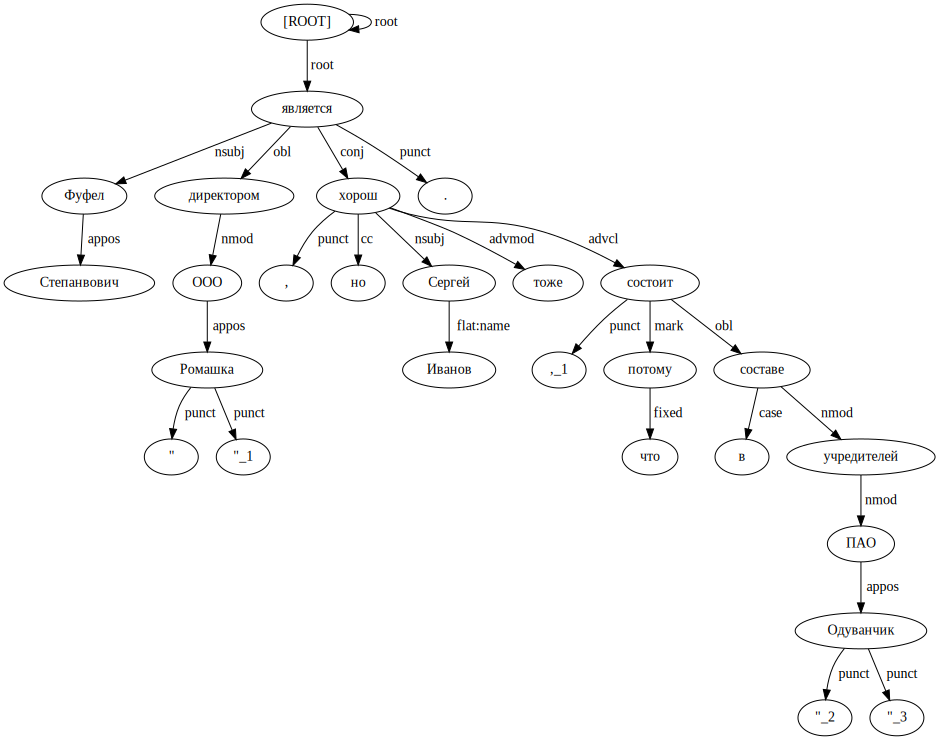

In [74]:
g = Digraph()

indices_head = mst(probs_arc_tmp)
indices_dep = list(range(len(tokens)))
indices_type = probs_type_tmp[indices_dep, indices_head].argmax(-1)

token2id = defaultdict(int)

def f(t):
    suffix = token2id[t]
    token2id[t] += 1
    if suffix:
        return f"{t}_{suffix}"
    else:
        return t

for i_head, i_dep, i_type in zip(indices_head, indices_dep, indices_type):        
    g.edge(tokens[i_head], f(tokens[i_dep]), label=id2arc[i_type])
    
g

* сохранение графа

In [75]:
g.render(filename="./graphs/fufel-stepanovich-sergei-ivanov.gv")

'./graphs/fufel-stepanovich-sergei-ivanov.gv.pdf'

* сохранение чекпоинта

In [60]:
import os
import json

parsers_dir = "./parsers-ckpt"
model_name = '70epochs-128bs-8attn-8heads-1mlp-1024arc_dim-256type_dim-2048dff-0.2 pos_emb_dropout-0.2attn_dropout-0.2elmo_dropout-0.2_combined_emb_dropout-0.2ff_dropout-emb_layernorm-noam_schedule-200_warmup_steps'
model_dir = os.path.join(parsers_dir, model_name)
os.makedirs(parsers_dir, exist_ok=True)

var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="dependency_parser")
saver = tf.train.Saver(var_list)
checkpoint_path = os.path.join(model_dir, "model.ckpt")
saver.save(sess, checkpoint_path)

config_path = os.path.join(model_dir, "config.json")
with open(config_path, "w") as f:
    json.dump(parser.config, f, indent=4, sort_keys=True)
    
with open(os.path.join(model_dir, "pos2id.json"), "w") as f:
    json.dump(pos2id, f, indent=4, sort_keys=True)

with open(os.path.join(model_dir, "arc2id.json"), "w") as f:
    json.dump(arc2id, f, indent=4, sort_keys=True)

* сохранение бинарника

In [57]:
import os

# вывод папочки
export_dir = "./parsers-bin"
os.makedirs(export_dir, exist_ok=True)
versions = os.listdir(export_dir)
if versions:
    last_version = max(int(x) for x in versions)
    new_version = last_version + 1
else:
    new_version = 1
export_dir = os.path.join(export_dir, str(new_version))

# saver
builder = tf.saved_model.builder.SavedModelBuilder(export_dir)

# входы
inputs = {
    "tokens": tf.saved_model.utils.build_tensor_info(parser.tokens_ph),
    "sequence_len": tf.saved_model.utils.build_tensor_info(parser.sequence_len_ph),
    "pos_ph": tf.saved_model.utils.build_tensor_info(parser.pos_ph),
    "training": tf.saved_model.utils.build_tensor_info(parser.training_ph),
}

# выходы
outputs = {
    "s_arc": tf.saved_model.utils.build_tensor_info(parser.s_arc),
    "s_type": tf.saved_model.utils.build_tensor_info(parser.s_type),
}

# сигнатура
prediction_signature = tf.saved_model.signature_def_utils.build_signature_def(
    inputs=inputs,
    outputs=outputs,
    method_name=tf.saved_model.PREDICT_METHOD_NAME
)

# записаь графа
builder.add_meta_graph_and_variables(
    sess=sess,
    tags=[tf.saved_model.SERVING],
    signature_def_map={
        tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY: prediction_signature
    },
    legacy_init_op=tf.tables_initializer()
)

# сохранение
builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./parsers-bin/1/saved_model.pb


b'./parsers-bin/1/saved_model.pb'